# Directed Acyclic Graphs

> **Reference:** *Causal Inference: The Mixtape*, Chapter 3: Directed Acyclic Graphs (pp. 67-117)

This lecture introduces directed acyclic graphs (DAGs) as a tool for reasoning about causal relationships. We apply these concepts using the Online Retail Simulator to answer: **Why does our naive analysis suggest content optimization hurts sales?**

---

## Part I: Theory

This section covers the theoretical foundations of directed acyclic graphs as presented in Cunningham's *Causal Inference: The Mixtape*, Chapter 3.

In [ ]:
# Theory visualization functions
from support import draw_dag, draw_movie_star_example, print_path_analysis

## 1. Introduction to DAG Notation

A **directed acyclic graph (DAG)** is a visual representation of causal relationships between variables.

### Core Components

| Element | Representation | Meaning |
|---------|----------------|----------|
| **Node** | Circle | A random variable |
| **Arrow** | Directed edge (→) | Direct causal effect |
| **Path** | Sequence of edges | Connection between variables |

### Key Properties

1. **Directed**: Arrows point in one direction (cause → effect)
2. **Acyclic**: No variable can cause itself (no loops)
3. **Causality flows forward**: Time moves in the direction of arrows

### What DAGs Encode

DAGs encode **qualitative causal knowledge**:
- What IS happening: drawn arrows
- What is NOT happening: missing arrows (equally important!)

A missing arrow from A to B claims that A does not directly cause B.

### Simple DAG: Treatment → Outcome

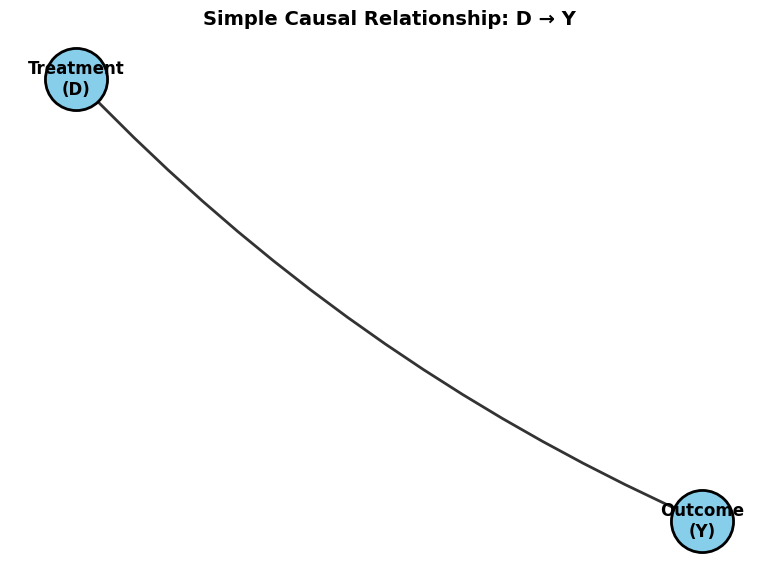

In [3]:
# Simplest DAG: D causes Y
draw_dag(
    edges=[("D", "Y")],
    node_labels={"D": "Treatment\n(D)", "Y": "Outcome\n(Y)"},
    title="Simple Causal Relationship: D → Y",
)

## 2. Paths: Direct and Backdoor

A **path** is any sequence of edges connecting two nodes, regardless of arrow direction.

### Types of Paths

| Path Type | Direction | Interpretation |
|-----------|-----------|----------------|
| **Direct/Causal** | D → ... → Y | The causal effect we want |
| **Backdoor** | D ← ... → Y | Spurious correlation (bias!) |

### The Backdoor Problem

Backdoor paths create **spurious correlations** between D and Y:
- They make D and Y appear related even without a causal effect
- This is the graphical representation of **selection bias**

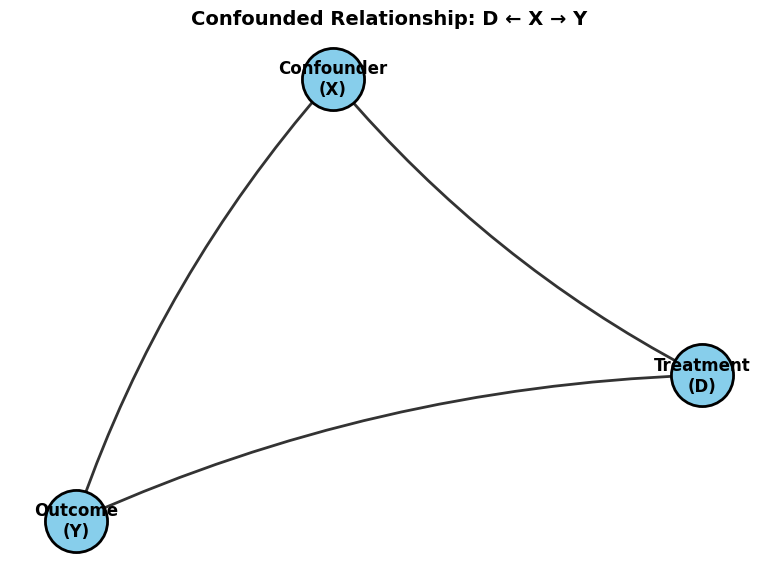

In [4]:
# DAG with confounder: classic triangle
draw_dag(
    edges=[("X", "D"), ("X", "Y"), ("D", "Y")],
    node_labels={"X": "Confounder\n(X)", "D": "Treatment\n(D)", "Y": "Outcome\n(Y)"},
    title="Confounded Relationship: D ← X → Y",
)

In [5]:
# Path analysis
print_path_analysis(
    paths=["D → Y", "D ← X → Y"],
    descriptions=["Direct causal path (what we want to estimate)", "Backdoor path (creates bias)"],
)

Path Analysis:

Path 1: D → Y
  Type: Direct causal path (what we want to estimate)

Path 2: D ← X → Y
  Type: Backdoor path (creates bias)


## 3. Confounders

A **confounder** is a variable that:
1. Causes the treatment (D)
2. Causes the outcome (Y)
3. Is NOT on the causal path from D to Y

### Observed vs. Unobserved

| Type | In DAG | Implication |
|------|--------|-------------|
| **Observed** | Solid circle | Can condition on it |
| **Unobserved** | Dashed circle | Cannot directly control |

### Classic Example: Education and Earnings

Consider estimating the return to education:
- **Treatment**: Years of education
- **Outcome**: Earnings
- **Confounders**: Ability, family background, motivation

People with higher ability tend to:
- Get more education (ability → education)
- Earn more regardless of education (ability → earnings)

This creates a backdoor path that inflates naive estimates of education's effect.

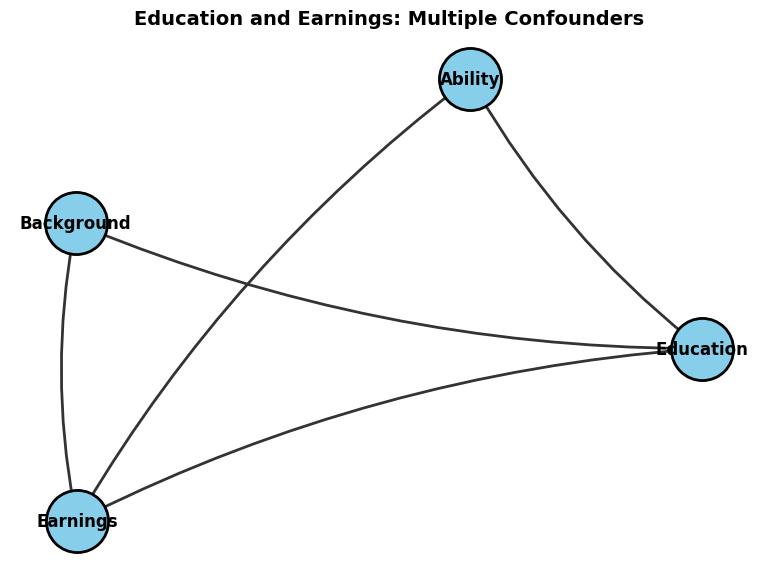

In [6]:
# Education-Earnings DAG with confounders
draw_dag(
    edges=[
        ("Ability", "Education"),
        ("Ability", "Earnings"),
        ("Background", "Education"),
        ("Background", "Earnings"),
        ("Education", "Earnings"),
    ],
    title="Education and Earnings: Multiple Confounders",
)

## 4. Colliders and Collider Bias

A **collider** is a variable where two arrows point INTO it:

$$D \rightarrow C \leftarrow Y$$

### Key Insight About Colliders

Colliders have a **special property**: they naturally BLOCK paths!

| Situation | Path Status |
|-----------|-------------|
| Leave collider alone | Path is CLOSED (blocked) |
| Condition on collider | Path is OPENED (creates bias!) |

### Why Conditioning Opens Colliders

Conditioning on a collider makes its causes appear correlated, even if they're independent in the population.

**Intuition**: If you know someone is a movie star (success), and they're not particularly beautiful, you infer they must be talented. This creates an artificial negative correlation between talent and beauty among stars.

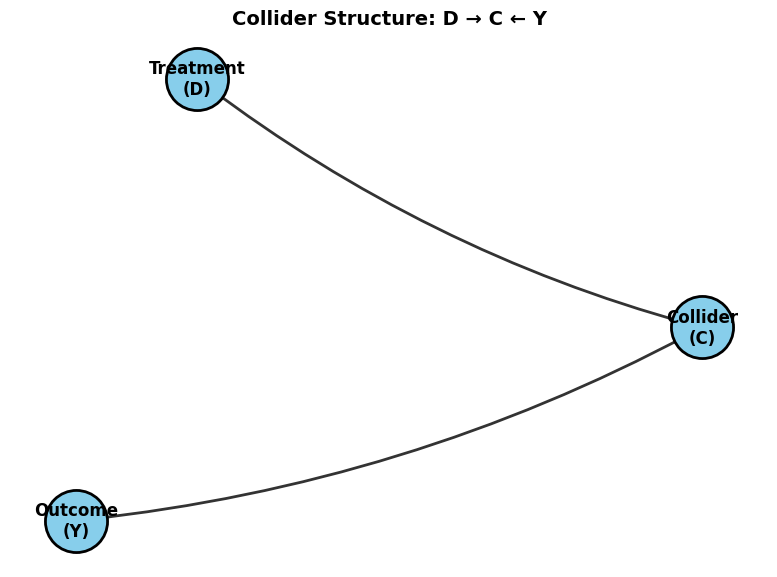

In [7]:
# Collider structure
draw_dag(
    edges=[("D", "C"), ("Y", "C")],
    node_labels={"D": "Treatment\n(D)", "C": "Collider\n(C)", "Y": "Outcome\n(Y)"},
    title="Collider Structure: D → C ← Y",
)

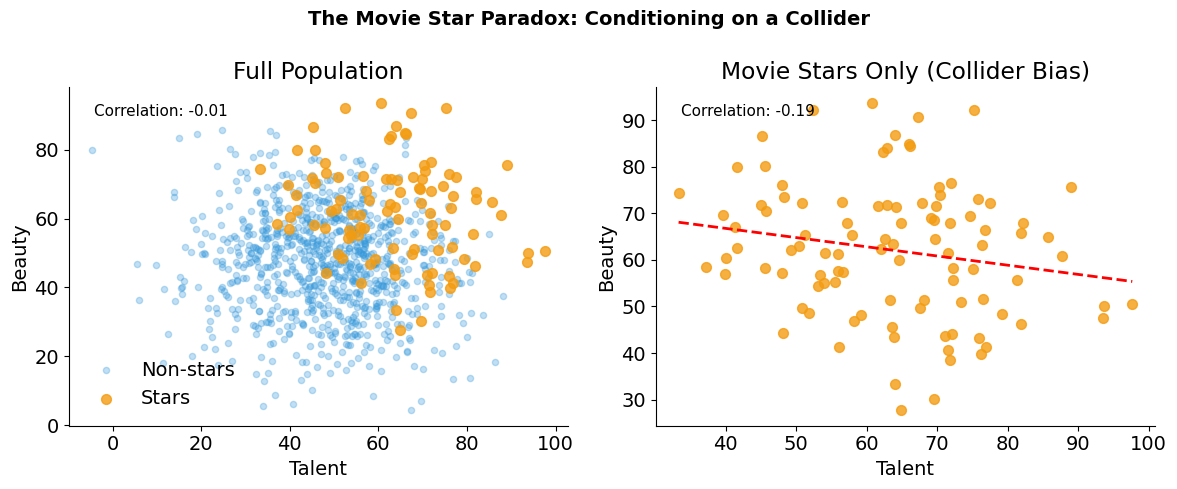


In the full population, talent and beauty are uncorrelated (r = -0.01)
Among movie stars, there's a NEGATIVE correlation (r = -0.19)

This is collider bias: conditioning on Star (which depends on both Talent and Beauty)
creates a spurious negative association between Talent and Beauty.


In [8]:
# Movie star example
draw_movie_star_example()

## 5. The Backdoor Criterion

The **backdoor criterion** provides a systematic way to identify what variables to condition on.

### Definition

A set of variables $Z$ satisfies the backdoor criterion relative to $(D, Y)$ if:

1. No variable in $Z$ is a descendant of $D$
2. $Z$ blocks every backdoor path from $D$ to $Y$

### How to Block Paths

| Node Type | To Block | To Open |
|-----------|----------|----------|
| **Non-collider** | Condition on it | Leave alone |
| **Collider** | Leave alone | Condition on it |

### Important Implications

1. **Not all controls are good controls**: Conditioning on a collider creates bias
2. **Minimal sufficiency**: You don't need to condition on everything—just enough to block backdoors
3. **Multiple solutions**: Often several valid conditioning sets exist

## 6. Classic Examples

### Example 1: The Movie Star Paradox

In Hollywood:
- Beauty and Talent are independent in the general population
- Both contribute to becoming a Star
- Among Stars, Beauty and Talent appear negatively correlated

**DAG**: Beauty → Star ← Talent

If you condition on Star (study only celebrities), you create a spurious negative correlation.

### Example 2: Discrimination in Hiring

Consider studying gender discrimination in wages:
- Gender → Occupation (women steered to lower-paying jobs)
- Gender → Wages (direct discrimination)
- Occupation → Wages

**Question**: Should we control for occupation?

**Answer**: It depends on what effect we want to measure!
- **Total effect**: Don't control (captures both direct and indirect discrimination)
- **Direct effect**: Control for occupation (discrimination within same job)

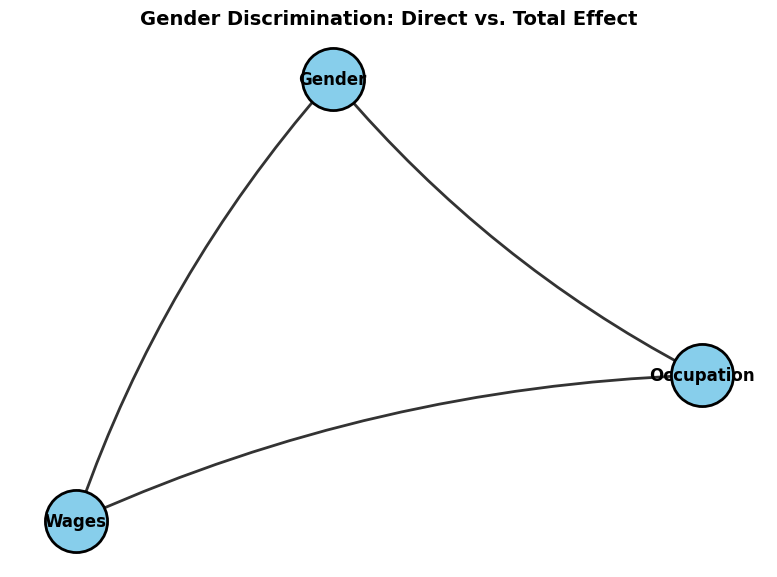

In [9]:
# Discrimination example
draw_dag(
    edges=[
        ("Gender", "Occupation"),
        ("Gender", "Wages"),
        ("Occupation", "Wages"),
    ],
    title="Gender Discrimination: Direct vs. Total Effect",
)

---

## Part II: Application

We now apply DAG concepts to diagnose and solve a confounding problem using simulated data.

In [ ]:
# Standard library
from operator import itemgetter

# Third-party packages
import matplotlib.pyplot as plt
import numpy as np

# Simulator
from online_retail_simulator import simulate, load_job_results

# Application imports (theory visualization already imported in Part I)
from support import (
    add_collider_variable,
    apply_confounded_treatment,
    create_quality_score,
    plot_confounding_scatter,
    plot_dag_application,
    plot_estimates_comparison,
    run_regression,
)

# Fix seed for reproducibility so that all results in this notebook are deterministic
np.random.seed(42)

## 1. Business Context: The Content Optimization Paradox

An e-commerce company ran a content optimization program for some of its products. When they analyze the results, they find something puzzling:

> **Products that received content optimization tend to have LOWER sales than those that didn't.**

The content team is confused. Did their optimization work actually hurt sales?

### The Underlying Reality

What's actually happening:
- **Struggling products** (low quality) were selected for content optimization
- **Strong products** (high quality) sell well without optimization
- Content optimization **does** increase sales (true causal effect is positive)

But the **confounding** from product quality creates a **negative spurious correlation** that overwhelms the positive causal effect. This is exactly the scenario we explored in Lecture 01—but now we'll use DAGs to understand and solve it.

## 2. Drawing the DAG

Let's represent this situation graphically:

- **Quality** (`Q`): Product quality/strength (unobserved)
- **Optimization** (`D`): Content optimization treatment
- **Sales** (`Y`): Revenue

Relationships:
1. Quality → Sales (+): Better products sell more
2. Quality → Optimization (−): Struggling products get optimized first
3. Optimization → Sales (+): Optimization increases sales (TRUE causal effect)

In [ ]:
# Content optimization paradox DAG
draw_dag(
    edges=[
        ("Quality", "Optimization"),
        ("Quality", "Sales"),
        ("Optimization", "Sales"),
    ],
    title="The Content Optimization Paradox: Quality Confounds the Treatment-Outcome Relationship",
)

In [ ]:
# Identify paths from Optimization to Sales
print_path_analysis(
    paths=["Optimization → Sales", "Optimization ← Quality → Sales"],
    descriptions=[
        "DIRECT PATH: True causal effect (+50% revenue boost)",
        "BACKDOOR PATH: Creates negative bias (quality confounding)",
    ],
)

## 3. Generating Data with the Online Retail Simulator

We use the **Online Retail Simulator** to generate realistic e-commerce data. The simulation configuration is defined in `"config_simulation.yaml"`. This gives us products with baseline sales metrics that we can then use to demonstrate confounding.

### Data Generation Process

1. **Simulate baseline data**: Generate products and their sales metrics
2. **Create quality score**: Derive a quality measure from baseline revenue (the confounder)
3. **Apply confounded treatment**: Assign content optimization based on quality (not randomly!)
4. **Calculate outcomes**: Apply the true treatment effect to get observed sales

In [ ]:
# Step 1: Generate baseline data using the simulator
! cat "config_simulation.yaml"

In [ ]:
# Run simulation
job_info = simulate("config_simulation.yaml")

In [ ]:
# Load simulation results
metrics = load_job_results(job_info)["metrics"]

print(f"Metrics records: {len(metrics)}")

### Creating the Confounded Treatment Assignment

Now we create the confounding structure:
1. **Quality score**: Derived from baseline revenue (high revenue → high quality)
2. **Treatment assignment**: Low quality products are more likely to be selected for optimization

This mimics a realistic business scenario where struggling products get prioritized for improvement.

In [ ]:
# Step 2: Create quality score from baseline revenue
quality_df = create_quality_score(metrics, seed=42)

# Step 3: Apply confounded treatment assignment
# Low quality products more likely to be optimized (negative quality_effect)
TRUE_EFFECT = 0.5  # 50% revenue boost from optimization
QUALITY_EFFECT = -0.05  # Negative: low quality products are more likely to be treated

confounded_products = apply_confounded_treatment(
    quality_df,
    treatment_fraction=0.3,
    quality_effect=QUALITY_EFFECT,
    true_effect=TRUE_EFFECT,
    seed=42,
)

print(f"Total products:     {len(confounded_products)}")
print(f"Optimized products: {confounded_products['D'].sum()} ({confounded_products['D'].mean():.1%})")
print(f"\nQuality score by treatment status:")
print(f"  Control (not optimized): {confounded_products[confounded_products['D'] == 0]['quality_score'].mean():.1f}")
print(f"  Treated (optimized):     {confounded_products[confounded_products['D'] == 1]['quality_score'].mean():.1f}")
print(f"\n-> Treated products have LOWER quality on average (confounding!)")

In [ ]:
# Visualize the confounding structure
plot_confounding_scatter(confounded_products, title="Confounding in Content Optimization")

## 4. What Does Naive Analysis Tell Us?

Let's start with what a naive analyst might do: compare average sales between optimized and non-optimized products.

In [ ]:
# Naive comparison: difference in means
treated = confounded_products[confounded_products["D"] == 1]
control = confounded_products[confounded_products["D"] == 0]

naive_estimate = treated["Y_observed"].mean() - control["Y_observed"].mean()

print("Naive Comparison: Optimized vs. Non-Optimized Products")
print("=" * 55)
print(f"Mean revenue (optimized):     ${treated['Y_observed'].mean():,.2f}")
print(f"Mean revenue (not optimized): ${control['Y_observed'].mean():,.2f}")
print(f"Naive estimate:               ${naive_estimate:,.2f}")
print(f"\nTrue effect: +{TRUE_EFFECT:.0%} revenue boost")
print(f"\n-> The naive estimate suggests optimization HURTS sales!")

## 5. How Do We Apply the Backdoor Criterion?

### Step 1: List all paths from Optimization to Sales

1. **Optimization → Sales** (direct, causal)
2. **Optimization ← Quality → Sales** (backdoor, non-causal)

### Step 2: Identify which paths are open/closed

- Path 1: Always open (it's causal)
- Path 2: Open because Quality is a non-collider on this path

### Step 3: Find conditioning set to block backdoors

To block the backdoor path **Optimization ← Quality → Sales**:
- Condition on **Quality**

This satisfies the backdoor criterion:
- Quality is not a descendant of Optimization
- Conditioning on Quality blocks the backdoor path

## 6. How Do We Recover the Causal Effect?

Now we condition on quality to close the backdoor path. We use regression to estimate the effect while controlling for the confounder.

In [ ]:
# Naive regression: Sales ~ Optimization (ignoring quality)
naive_results = run_regression(confounded_products, "Y_observed", ["D"])

# Conditioned regression: Sales ~ Optimization + Quality
conditioned_results = run_regression(confounded_products, "Y_observed", ["D", "quality_score"])

print("Naive Regression: Y ~ D")
print("=" * 50)
print(naive_results.summary().tables[1])

print("\n\nConditioned Regression: Y ~ D + Quality")
print("=" * 50)
print(conditioned_results.summary().tables[1])

print(f"\nNaive estimate:       ${naive_results.params['D']:,.2f}")
print(f"Conditioned estimate: ${conditioned_results.params['D']:,.2f}")
print(f"True effect:          +{TRUE_EFFECT:.0%} boost")
print(f"\n-> Conditioning on quality recovers the POSITIVE effect!")

In [ ]:
# Visual summary
plot_dag_application(
    confounded_products,
    naive_effect=naive_results.params["D"],
    conditioned_effect=conditioned_results.params["D"],
    true_effect=TRUE_EFFECT,
)

## 7. What Happens When We Condition on a Collider?

Now let's see what happens when we condition on a **collider**.

### Adding a Collider: "High Performer" Status

Suppose the company flags products as "High Performers" if they have:
- Received content optimization, OR
- High sales revenue

This creates a collider:
$$\text{Optimization} \rightarrow \text{High Performer} \leftarrow \text{Sales}$$

In [ ]:
# DAG with collider
draw_dag(
    edges=[
        ("Quality", "Optimization"),
        ("Quality", "Sales"),
        ("Optimization", "Sales"),
        ("Optimization", "HighPerformer"),
        ("Sales", "HighPerformer"),
    ],
    title="Extended DAG: High Performer Status is a Collider",
)

In [ ]:
# Add collider variable
THRESHOLD_PCT = 70  # Percentile threshold for high performer classification

confounded_products = add_collider_variable(
    confounded_products, revenue_col="Y_observed", treatment_col="D", threshold_pct=THRESHOLD_PCT, seed=42
)

high_count = confounded_products["high_performer"].sum()
high_pct = confounded_products["high_performer"].mean()
print(f"High performer products: {high_count} ({high_pct:.1%})")

In [ ]:
# What happens if we condition on the collider?
high_performer_df = confounded_products[confounded_products["high_performer"]]

# Regression on high performers only (conditioning on collider)
collider_results = run_regression(high_performer_df, "Y_observed", ["D", "quality_score"])

print("Regression CONDITIONING ON COLLIDER (High performers only):")
print("=" * 60)
print(f"Optimization effect estimate: ${collider_results.params['D']:,.2f}")
print(f"True effect:                  +{TRUE_EFFECT:.0%} boost")
print(f"\n-> Conditioning on the collider BIASES our estimate!")

In [ ]:
# Compare estimates across all three scenarios
estimates = {
    "Naive\n(ignoring\nquality)": naive_results.params["D"],
    "Conditioned\n(on quality)": conditioned_results.params["D"],
    "Collider bias\n(high performers\nonly)": collider_results.params["D"],
}

plot_estimates_comparison(estimates)

In [ ]:
# Final summary
print("\n" + "=" * 60)
print("SUMMARY: Content Optimization Effect Estimates")
print("=" * 60)
print(f"True causal effect:                  +{TRUE_EFFECT:.0%} revenue boost")
print(f"\nNaive (ignoring quality):            ${naive_results.params['D']:,.2f}  ← WRONG SIGN!")
print(f"Conditioned on quality (correct):    ${conditioned_results.params['D']:,.2f}  ← POSITIVE!")
print(f"Conditioned on collider (biased):    ${collider_results.params['D']:,.2f}  ← ATTENUATED!")
print("=" * 60)

## Additional resources

- **Bellemare, M. & Bloem, J. (2020)**. The paper of how: Estimating treatment effects using the front-door criterion. *Working Paper*.

- **Hünermund, P. & Bareinboim, E. (2019)**. Causal inference and data-fusion in econometrics. *arXiv preprint arXiv:1912.09104*.

- **Imbens, G. W. (2020)**. Potential outcome and directed acyclic graph approaches to causality: Relevance for empirical practice in economics. *Journal of Economic Literature*, 58(4), 1129-1179.

- **Manski, C. F. (1995)**. *Identification Problems in the Social Sciences*. Harvard University Press.

- **Morgan, S. L. & Winship, C. (2014)**. *Counterfactuals and Causal Inference*. Cambridge University Press.

- **Pearl, J. (2009a)**. *Causality: Models, Reasoning, and Inference* (2nd ed.). Cambridge University Press.

- **Pearl, J. (2009b)**. Causal inference in statistics: An overview. *Statistics Surveys*, 3, 96-146.

- **Pearl, J. (2012)**. The do-calculus revisited. *Proceedings of the 28th Conference on Uncertainty in Artificial Intelligence*.

- **Peters, J., Janzing, D. & Schölkopf, B. (2017)**. *Elements of Causal Inference: Foundations and Learning Algorithms*. MIT Press.